# Figure 2: RNA Structure Cross-Validation Analysis

This notebook generates Figure 2 from the manuscript, which shows:
- **Fig 2a**: Loss from cross-validation fitting of Nano-DMS-MaP data
- **Fig 2b**: Loss with soft constraints from PDB and Vienna MFE structures
- **Fig 2c**: Distances analysis between PDB and model output (after soft constraints fit), Vienna, and Vienna MFE
- **Fig 2d**: 

In [24]:
# Import required libraries
from tqdm import tqdm
from itertools import combinations
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import RNA

# Add RNA structure analysis path
from class_experiment import clocked, Experiment, initialise_combined_cspA_exp
from class_experimentfit import ExperimentFit, MultiSystemsFit

## Configuration and Data Setup

Setting up the analysis parameters and verifying that all required fit results exist.

In [25]:
# Configuration
RNA_STRUCT_HOME = '.'
FOLDER = 'fits/red_crossval_1'  # folder where the fits are stored, change as needed
systems = ['hc16', 'bact_RNaseP_typeA', 'tetrahymena_ribozyme', 'HCV_IRES', 'V_chol_gly_riboswitch']

# Verify all required subfolders exist
subfolders = [f'red_crossval_{sys1}_{sys2}_{sys3}' for sys1, sys2, sys3 in combinations(systems, 3)]
subfolders_fullpath = [os.path.join(RNA_STRUCT_HOME, FOLDER, subfolder) for subfolder in subfolders]

print(f"Checking {len(subfolders)} cross-validation combinations...")
missing_folders = [folder for folder in subfolders_fullpath if not os.path.exists(folder)]
if missing_folders:
    raise FileNotFoundError(f"Missing folders: {missing_folders}")
else:
    print("✓ All required fit result folders found")
    print(f"✓ Systems: {', '.join(systems)}")

Checking 10 cross-validation combinations...
✓ All required fit result folders found
✓ Systems: hc16, bact_RNaseP_typeA, tetrahymena_ribozyme, HCV_IRES, V_chol_gly_riboswitch


## Helper Functions

Functions to initialize experiments and compute system-specific losses.

In [26]:
def initialize_exps(sys1, sys2, sys3):
    """Initialize training and validation experiments for a given system combination."""
    # Get training experiments (3 systems)
    exps_train = [Experiment(path) for path in Experiment.paths_to_redmond_ivt_data_txt 
                  if Experiment(path).system in (sys1, sys2, sys3)]
    # Remove 85mM data
    exps_train = [exp for exp in exps_train if exp.conc_mM != 85]
    assert len(exps_train) == 3 * 5 * 2, f'Expected {3 * 5 * 2} experiments, got {len(exps_train)}'
    
    # Get validation experiments (remaining 2 systems)
    exps_val = [Experiment(path) for path in Experiment.paths_to_redmond_ivt_data_txt 
                if Experiment(path).system not in (sys1, sys2, sys3)]
    # Remove 85mM data
    exps_val = [exp for exp in exps_val if exp.conc_mM != 85]
    assert len(exps_val) == 2 * 5 * 2, f'Expected {2 * 5 * 2} experiments, got {len(exps_val)}'
    
    return exps_train, exps_val

In [27]:
def compute_system_loss(sys1, sys2, sys3, multi_exp_dict):
    """Compute the loss for each system in a MultiSystemsFit."""
    multi_exp = multi_exp_dict[(sys1, sys2, sys3)]
    subfolder = f'red_crossval_{sys1}_{sys2}_{sys3}'
    subfolder_fullpath = os.path.join(RNA_STRUCT_HOME, FOLDER, subfolder)
    
    # Load fitted parameters
    params_file = os.path.join(subfolder_fullpath, 'params1D.txt')
    assert os.path.exists(params_file), f'Params file {params_file} does not exist'
    
    # Compute losses
    multi_exp.multisys_loss_and_grad(np.loadtxt(params_file), compute_gradient=False)
    
    loss_per_system = {sys_.sys_name: 0 for sys_ in multi_exp.systems}
    is_validation = {sys_.sys_name: np.nan for sys_ in multi_exp.systems}
    
    for i, system in enumerate(multi_exp.systems):
        exp_fits = multi_exp.systems[i].exp_fits_all
        for exp_fit in exp_fits:
            ID = exp_fit.ID
            assert exp_fit.seq == multi_exp.systems[i].seq, f'Sequence mismatch for {ID}'
            loss_exp = multi_exp.losses_exp_fit[ID]
            # Normalize loss by sequence length and number of experiments
            normalised_loss = loss_exp / (exp_fit.N_seq - 50)
            normalised_loss /= 5*2
            loss_per_system[system.sys_name] += normalised_loss 
            is_validation[system.sys_name] = not exp_fit.is_training
    
    assert np.nan not in is_validation.values(), "is_validation should not contain NaN values"
    return loss_per_system, is_validation

## Figure 2a: Cross-Validation Loss Analysis

Loading fitted parameters and computing losses for each system across all cross-validation folds.

In [33]:
# Initialize MultiSystemsFit objects for all combinations
print("Initializing experiment combinations...")
multi_exp_dict = {}
for sys1, sys2, sys3 in tqdm(combinations(systems, 3), desc="Loading experiments"):
    exps_train, exps_val = initialize_exps(sys1, sys2, sys3)
    multi_exp = MultiSystemsFit(exps_train, validation_exps=exps_val)
    multi_exp_dict[(sys1, sys2, sys3)] = multi_exp

print(f"✓ Loaded {len(multi_exp_dict)} experiment combinations")

Initializing experiment combinations...


Loading experiments: 10it [00:02,  4.82it/s]

✓ Loaded 10 experiment combinations


In [34]:
# Compute losses for each system across all cross-validation folds
print("Computing system losses...")
losses_per_system = {sys: [] for sys in systems}
is_validation_per_system = {sys: [] for sys in systems}

for (sys1, sys2, sys3) in tqdm(combinations(systems, 3), desc="Computing losses", total=len(multi_exp_dict)):
    loss_per_system, is_validation = compute_system_loss(sys1, sys2, sys3, multi_exp_dict)
    for sys_name, loss in loss_per_system.items():
        losses_per_system[sys_name].append(loss)
        is_validation_per_system[sys_name].append(is_validation[sys_name])

print("✓ Loss computation completed")

Computing system losses...


Computing losses:  70%|███████   | 7/10 [00:31<00:13,  4.57s/it]


KeyboardInterrupt: 

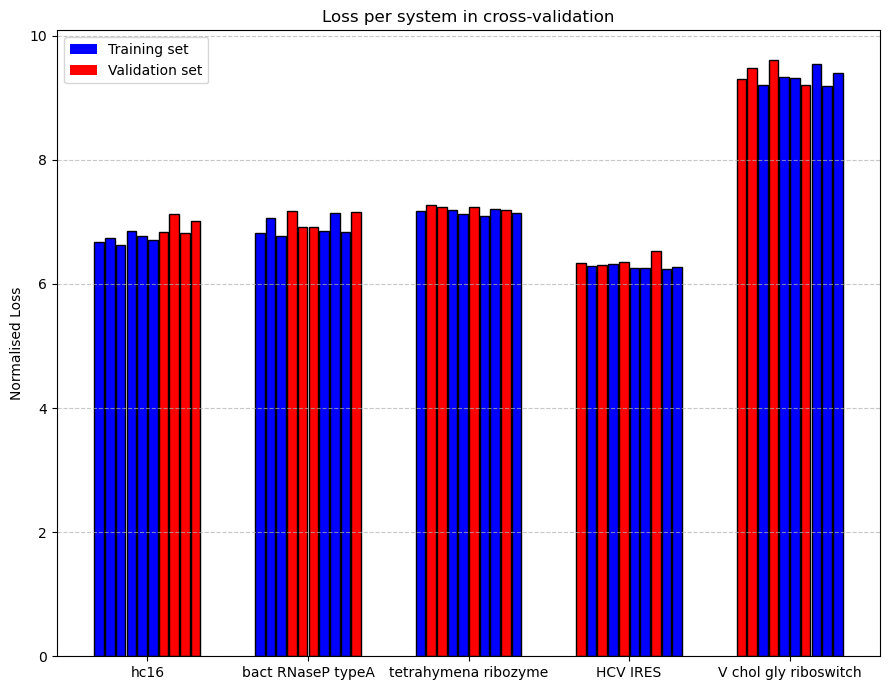

In [ ]:
# Generate Figure 2a
plt.figure(figsize=(9, 7))

# Create bar plot: x-axis is system, y-axis is loss, color indicates validation/training
x = np.arange(len(systems))
bar_width = 0.06

for i, sys_name in enumerate(systems):
    losses = losses_per_system[sys_name]
    colors = ['red' if is_val else 'blue' for is_val in is_validation_per_system[sys_name]]
    
    # Position bars with slight offset for each fold
    positions = i + np.linspace(-0.3, 0.3, len(losses))
    plt.bar(positions, losses, color=colors, edgecolor='k', width=bar_width)

plt.ylabel('Normalised Loss')
plt.title('Loss per system in cross-validation')
systems_labels = [sys_name.replace("_", " ") for sys_name in systems]
plt.xticks(x, systems_labels, rotation=0)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Training set'),
    Patch(facecolor='red', label='Validation set')
]
plt.legend(handles=legend_elements)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Figure 2b: Soft Constraints Analysis

Analyzing the effect of soft constraints derived from PDB structures vs MFE structures on the loss function.


In [ ]:
# Load physical parameters from all cross-validation fits
print("Loading physical parameters...")
physical_params_dict = {}
for (sys1, sys2, sys3) in tqdm(combinations(systems, 3), desc="Loading parameters"):
    subfolder = f'red_crossval_{sys1}_{sys2}_{sys3}'
    subfolder_fullpath = os.path.join(RNA_STRUCT_HOME, FOLDER, subfolder)
    params_file = os.path.join(subfolder_fullpath, 'params1D.txt')
    params_1D = np.loadtxt(params_file)
    physical_params_dict[(sys1, sys2, sys3)] = params_1D

print(f"✓ Loaded parameters for {len(physical_params_dict)} parameter sets")

Loading physical parameters...


Loading parameters: 10it [00:00, 2391.14it/s]

✓ Loaded parameters for 10 parameter sets


Generating soft constraints analysis for hc16...


Processing parameter sets:   0%|          | 0/10 [00:31<?, ?it/s]


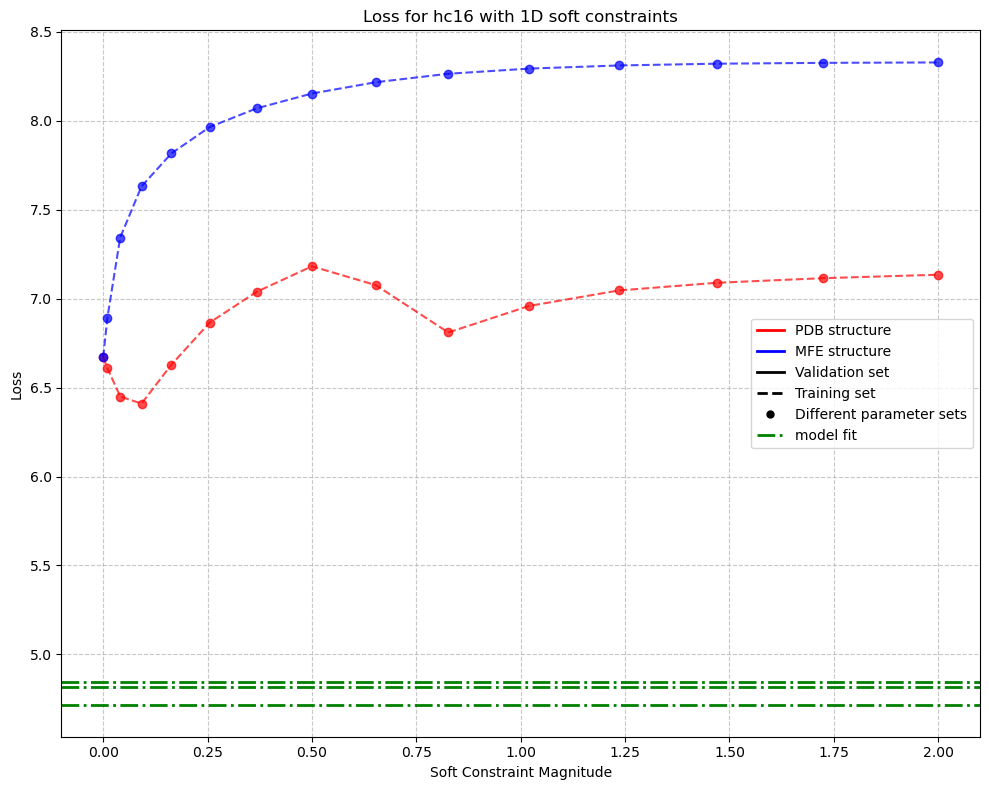

Skipping bact_RNaseP_typeA - no PDB data available
Generating soft constraints analysis for tetrahymena_ribozyme...


Processing parameter sets:   0%|          | 0/10 [00:44<?, ?it/s]


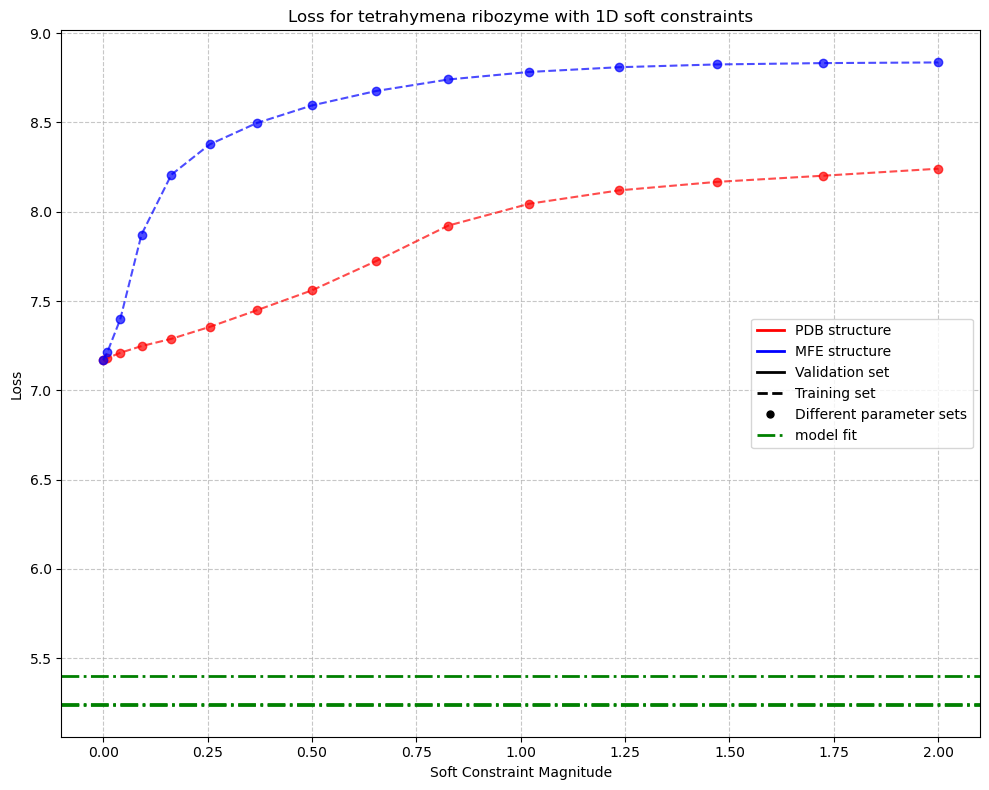

Generating soft constraints analysis for HCV_IRES...


Processing parameter sets:   0%|          | 0/10 [00:35<?, ?it/s]


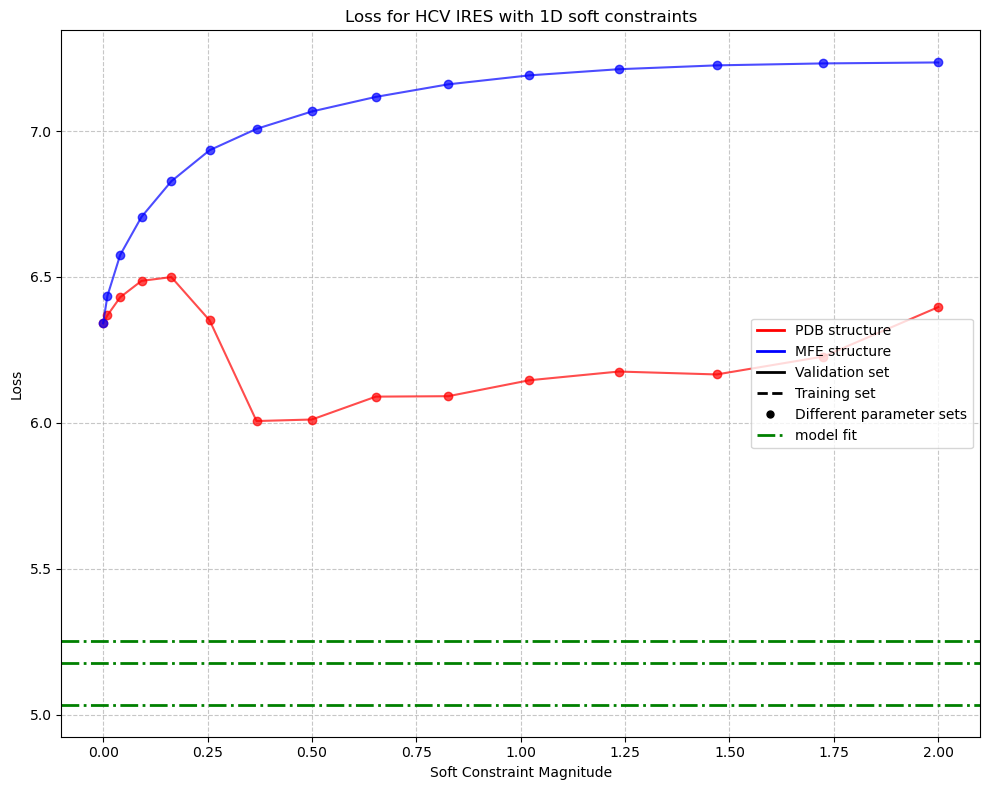

Generating soft constraints analysis for V_chol_gly_riboswitch...


Processing parameter sets:   0%|          | 0/10 [00:11<?, ?it/s]


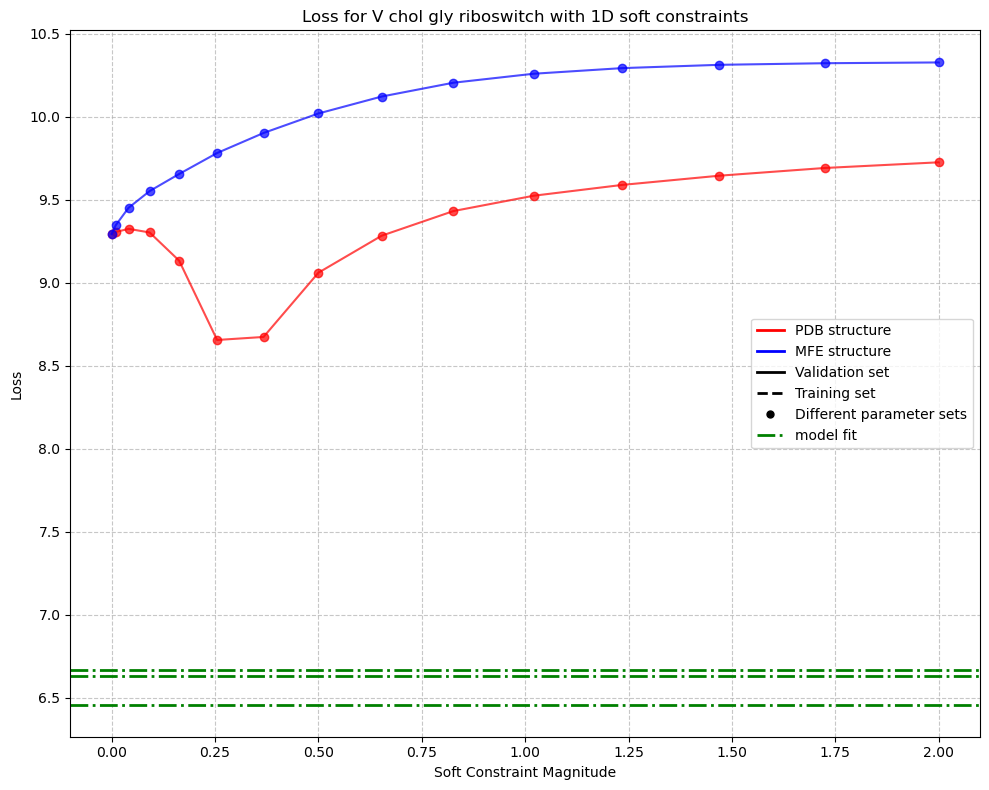

In [49]:
# Generate Figure 2b for each system (except bact_RNaseP_typeA which has no PDB data)
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
model_fit_params_folders = [f'fits/red_sep_fix_{i}' for i in range(1,4)]
optimal_lambda_magnitude_per_system = {}
for system in systems:
    if system == 'bact_RNaseP_typeA':
        print(f"Skipping {system} - no PDB data available")
        continue
    
    print(f"Generating soft constraints analysis for {system}...")
    plt.figure(figsize=(10, 8))
    
    # Initialize experiments for this system
    exps = [Experiment(path) for path in Experiment.paths_to_redmond_ivt_data_txt 
            if Experiment(path).system == system]
    exps = [exp for exp in exps if exp.conc_mM != 85]  # remove 85mM data
    multi_exp = MultiSystemsFit(exps, infer_1D_sc=True)
    # loss from model fit
    exp = exps[0]
    for folder in model_fit_params_folders:
        params_file = os.path.join(RNA_STRUCT_HOME, folder, f'{system}_with_lambdas','params1D.txt')
        params_1D = np.loadtxt(params_file)
        loss, _ = multi_exp.multisys_loss_and_grad(params_1D=params_1D, compute_gradient=False)
        # normalize
        loss = loss / (exp.N_seq - 50)
        loss /= 5*2
        # plot dashed horizontal line
        plt.axhline(y=loss, color='green', linestyle='-.', lw=2, 
                    label=f'Model fit {folder.split("_")[-1]} set' if folder.split("_")[-1].isdigit() else folder.split("_")[-1])
    # Get sequence and PDB secondary structure
    exp.add_pdb_ss_to_df(exp.raw_df)
    ss_pdb = ''.join(exp.df['pdb_ss'])
    
    # Test different constraint magnitudes
    lambdas_magnitude = (np.linspace(0, np.sqrt(2), 15))**2  # quadratic spacing
    
    for set_i_params, (systems_train, physical_params) in tqdm(enumerate(physical_params_dict.items()), desc="Processing parameter sets", total=len(physical_params_dict)):
        marker = markers[set_i_params % len(markers)]
        is_training = system in systems_train
        
        # Test both PDB and MFE structure constraints
        for structure in ['pdb1D', 'mfe1D']:
            color = 'red' if structure == 'pdb1D' else 'blue'
            
            # Define reference structure
            if structure == 'pdb1D':
                ref_struct = ss_pdb
            elif structure == 'mfe1D':
                fc = RNA.fold_compound(exp.seq)
                RNA.cvar.temperature = exp_fit.temp_C
                exp_fit = multi_exp.systems[0].exp_fits_all[0]
                ref_struct = fc.mfe()[0]
            
            # Convert structure to constraint vector
            is_paired = np.array([-1 if nb in '()' else 1 if nb == '.' else 0 for nb in ref_struct])
            
            losses = []
            for lambda_magnitude in lambdas_magnitude:
                lambda_sc = is_paired * lambda_magnitude
                params_1D = np.append(physical_params.copy(), lambda_sc)
                loss, _ = multi_exp.multisys_loss_and_grad(params_1D=params_1D, compute_gradient=False)
                # normalize
                loss = loss / (exp.N_seq - 50)
                loss /= 5*2
                losses.append(loss)
            
            ls = '--' if is_training else '-'
            plt.plot(lambdas_magnitude, losses, color=color, linestyle=ls, 
                    marker=marker, markersize=6, alpha=0.7, 
                    label=f'{structure}_set{set_i_params}' if set_i_params < 3 else "")
            if structure == 'pdb1D' and set_i_params == 0:
                # find where loss is minimal
                optimal_index = np.argmin(losses)
                optimal_lambda_magnitude = lambdas_magnitude[optimal_index]
                optimal_lambda_magnitude_per_system[system] = optimal_lambda_magnitude
        break
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='PDB structure'),
        Line2D([0], [0], color='blue', lw=2, label='MFE structure'),
        Line2D([0], [0], color='black', linestyle='-', lw=2, label='Validation set'),
        Line2D([0], [0], color='black', linestyle='--', lw=2, label='Training set'),
        Line2D([0], [0], color='black', marker='o', linestyle='None', 
               markersize=5, label='Different parameter sets'),
        Line2D([0], [0], color='green', linestyle='-.', lw=2, label='model fit')
    ]
    
    plt.xlabel('Soft Constraint Magnitude')
    plt.ylabel('Loss')
    plt.title(f'Loss for {system.replace("_", " ")} with 1D soft constraints')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Figure 2c: Distance Analysis

This analysis examines the distances between the PDB structure and the following:
- The model output
- Vienna
- Vienna MFE


In [ ]:
def dotbracket_to_matrix(dotbracket):
    '''Creates a pairing matrix from a dotbracket string.'''
    matrix = np.zeros((len(dotbracket), len(dotbracket)))
    # Stack for holding the indices of opening brackets
    stack = []
    for i, char in enumerate(dotbracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            matrix[i][j] = 1
            matrix[j][i] = 1
        elif char == '.':
            pass
        elif char == '-':
            matrix[i][:] = np.nan
            matrix[:, i] = np.nan
        else:
            raise ValueError('Invalid character in dotbracket string')
    assert len(stack) == 0
    return matrix

def compute_distance(bpp1, bpp2):
    dist = 0
    n = 0
    for i in range(bpp1.shape[0]):
        for j in range(i+1, bpp1.shape[1]):
            if not np.isnan(bpp1[i, j]) and not np.isnan(bpp2[i, j]):
                dist += (bpp1[i, j] - bpp2[i, j])**2
                n += 1
    return np.sqrt(dist / n) 

     

all_exps = [Experiment(path) for path in Experiment.paths_to_redmond_ivt_data_txt]
systems_with_pdb = [sys_ for sys_ in systems if sys_ != 'bact_RNaseP_typeA']
distance_vienna_bpp = {}
distance_vienna_MFE = {}
bpp_pdb_dict = {}
for i, system in enumerate(systems_with_pdb):
    # Initialize experiments for this system
    exps = [exp for exp in all_exps if exp.system == system]
    exps = [exp for exp in exps if exp.conc_mM != 85]  # remove 85mM data
    exps[0].add_pdb_ss_to_df(exps[0].raw_df)
    ss_pdb = ''.join(exps[0].raw_df['pdb_ss'])
    bpp_pdb_fullseq = dotbracket_to_matrix(ss_pdb)

    # select the right indices
    indices = exps[0].df.index
    assert ''.join(exps[0].df['ref_nt']) == ''.join(exps[0].raw_df['ref_nt'][indices])
    bpp_pdb = bpp_pdb_fullseq[indices][:, indices]

    fc = RNA.fold_compound(exps[0].seq)
    RNA.cvar.temperature = exps[0].temp_C
    ss_vienna = fc.mfe()[0]
    bpp_vienna_MFE = dotbracket_to_matrix(ss_vienna)
    fc.pf()
    bpp_vienna_fc = np.array(fc.bpp())[1:, 1:]  

    distance_vienna_bpp[system] = compute_distance(bpp_pdb, bpp_vienna_fc)
    distance_vienna_MFE[system] = compute_distance(bpp_pdb, bpp_vienna_MFE)
    bpp_pdb_dict[system] = bpp_pdb
FOLDER2 = 'fits/red_crossval_sc_3'  # folder where the fits with soft constraints are stored
# Model bpp distances
model_bpp_distances = {system: [] for system in systems_with_pdb}
model_is_validation = {system: [] for system in systems_with_pdb}
for (sys1, sys2, sys3) in tqdm(combinations(systems, 3), desc="Loading model BPP distances"):
    subfolder = f'red_crossval_{sys1}_{sys2}_{sys3}_with_lambdas'
    subfolder_fullpath = os.path.join(RNA_STRUCT_HOME, FOLDER2, subfolder)
    params_file = os.path.join(subfolder_fullpath, 'params1D.txt')
    params_1D = np.loadtxt(params_file)
    
    exps_train, exps_val = initialize_exps(sys1, sys2, sys3)
    multi_exp = MultiSystemsFit(exps_train, validation_exps=exps_val, infer_1D_sc=True)
    
    
    for i, system in enumerate(multi_exp.systems):
        if system.sys_name == 'bact_RNaseP_typeA':
            continue
        exp_fits = multi_exp.systems[i].exp_fits_all
        # take the one with 0 conc
        exp_fits = [exp_fit for exp_fit in exp_fits if exp_fit.conc_mM == 0]
        assert len(exp_fits) == 2, f'Expected 2 experiment fit for {system.sys_name}, got {len(exp_fits)}'
        exp_fit = exp_fits[0]
        fold_compound = RNA.fold_compound(exp_fit.seq)
        RNA.cvar.temperature = exp_fit.temp_C
        # apply penalty for paired bases
        # apply soft constraints from lambda_sc
        lambda_sc = params_1D[multi_exp.lambdas_indices[system.sys_name]]
        exp_fit.apply_soft_constraints(lambda_sc, fold_compound)
        # compute pairing probabilities
        fold_compound.pf()
        bpp = np.array(fold_compound.bpp())[1:,1:]
        distance_to_pdb = compute_distance(bpp, bpp_pdb_dict[system.sys_name])
        model_bpp_distances[system.sys_name].append(distance_to_pdb)
        model_is_validation[system.sys_name].append(not exp_fit.is_training)

single_system_folders = [f'fits/red_sep_fix_{i}' for i in range(1, 4)]  # folders for single system fits
single_system_bpps = { system: dict() for system in systems_with_pdb }

for system in systems_with_pdb:
    for folder in single_system_folders:
        exp = [Experiment(path_) for path_ in Experiment.paths_to_redmond_ivt_data_txt 
               if Experiment(path_).system == system and Experiment(path_).conc_mM == 0]
        assert len(exp) == 2
        exp = exp[0]
        multi_exp = MultiSystemsFit([exp], infer_1D_sc=True)
        exp_fit = multi_exp.systems[0].exp_fits_all[0]

        try:
            params_1D = np.loadtxt(os.path.join(RNA_STRUCT_HOME, folder, f'{system}_with_lambdas', 'params1D.txt'))
        except FileNotFoundError:
            print(f"Params file for {system} not found, skipping...")
            single_system_bpps[system] = None
            continue

        fold_compound = RNA.fold_compound(exp.seq)
        exp_fit.apply_soft_constraints(params_1D[multi_exp.lambdas_indices[system]], fold_compound)
        bpp = np.array(fold_compound.bpp())[1:,1:]
        single_system_bpps[system][folder] = bpp
        #plt.imshow(bpp, cmap='binary', vmin=0, vmax=1)


Loading model BPP distances: 10it [00:11,  1.16s/it]


['............(((...((((((,..((((((((....(((((.....((({{((((((((.{(((.{((....))}.})}},|((|,.....))}).)))).....)))))))).....)))))..)).))))))...}|},...(((((((((....))))))))).{((((........))))}.{((((({.{{{...,,......,))))),))}}((((((((....)))))))).....((((((......)))))){{,...(((((((............))))))).....)).)))...)))....', -111.85484313964844]
['............(((...((((((,..((((((((....(((((.....((({{((((((((.{(((.{((....))}.})}},|((|,.....))}).)))).....)))))))).....)))))..)).))))))...}|},...(((((((((....))))))))).{((((........))))}.{((((({.{{{...,,......,))))),))}}((((((((....)))))))).....((((((......)))))){{,...(((((((............))))))).....)).)))...)))....', -111.85484313964844]
['.,,..((,..........((((((((.{{(((((({,.{(,....,{,{{{|||{,,,.||..,{{{..{{,...}},.}}},.{(((......)))|.,,.......}}},,,||...||,||||..}},,||,,,....,{{...,((((((({....)))))))),..|||,.......,},}},.|}........,}}}}}}}}},..))))))))...{((((((....)))))))}.,,.......||.........,...}}..(((((((............)))))))...}}....},,,

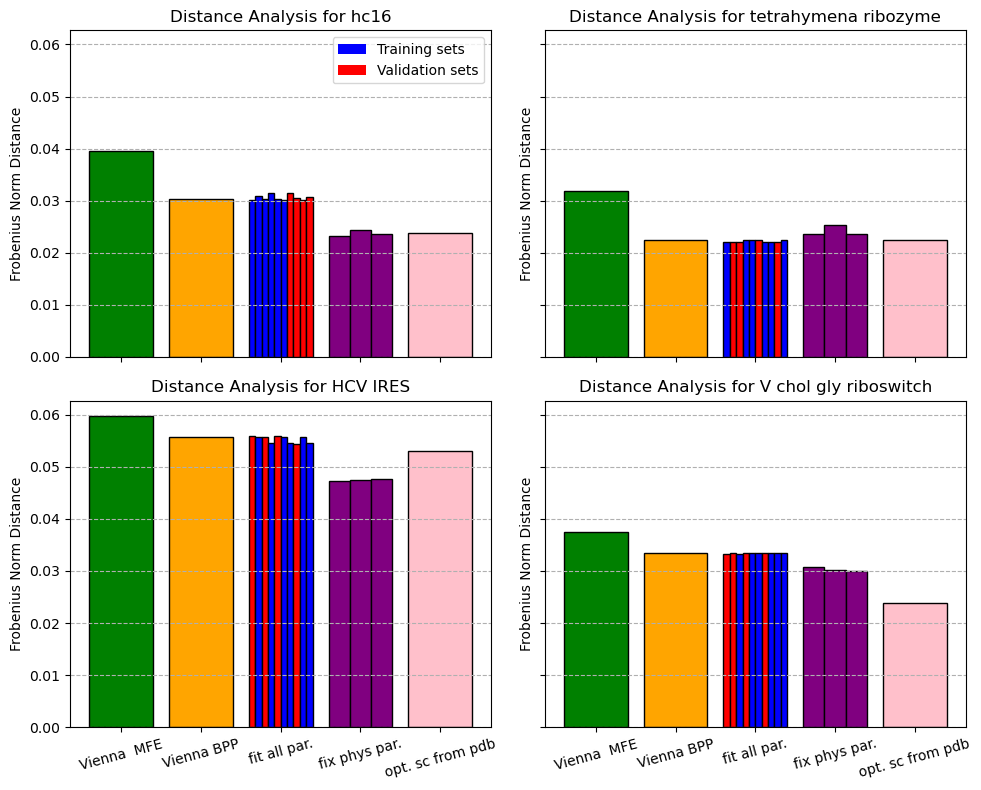

In [57]:
figs, axs = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)
#%%
for i, system in enumerate(systems_with_pdb):
    # bar plot
    ax = axs.flatten()[i]
    bar_width = 0.8  # Standard bar width
    
    # Plot first two bars normally
    ax.bar([0,1], [ distance_vienna_MFE[system], distance_vienna_bpp[system]],
           color=['green', 'orange'], edgecolor='k', width=bar_width)

    distances_model_output = model_bpp_distances[system]
    colors = [col for col in model_is_validation[system]]
    colors = ['red' if is_val else 'blue' for is_val in colors]
    
    # Calculate positions for model output bars to fit within same width as other bars
    n_model_bars = len(distances_model_output)
    model_bar_width = bar_width / n_model_bars
    start_pos = 2 - bar_width/2  # Start position for model output bars
    positions = [start_pos + i * model_bar_width + model_bar_width/2 for i in range(n_model_bars)]
    
    # Plot model output bars with calculated positions and width
    ax.bar(positions, distances_model_output, color=colors, edgecolor='k', 
           width=model_bar_width)  # 0.9 to add small gaps between bars
    # plot single system bpp
    single_bpp_system_list = [single_system_bpps[system][folder] for folder in single_system_folders if system == system]
    if single_bpp_system_list is not None:
        single_bpp_distances = []
        n_model_bars = len(single_bpp_system_list)
        model_bar_width = bar_width / n_model_bars
        start_pos = 3 - bar_width/2  # Start position for model output bars
        positions = [start_pos + i * model_bar_width + model_bar_width/2 for i in range(n_model_bars)]
        for single_bpp in single_bpp_system_list:
            # Compute distance for each single system fit
            single_bpp_distance = compute_distance(single_bpp, bpp_pdb_dict[system])
            single_bpp_distances.append(single_bpp_distance)
        ax.bar(positions, single_bpp_distances, color='purple', edgecolor='k',width=model_bar_width)
    else:
        single_bpp_distance = np.nan

    # add bar with optimal constrains from pdb
    exps = [Experiment(path) for path in Experiment.paths_to_redmond_ivt_data_txt 
            if Experiment(path).system == system]
    exps = [exp for exp in exps if exp.conc_mM != 85]  # remove 85mM data
    multi_exp = MultiSystemsFit(exps, infer_1D_sc=True)
    # loss from model fit
    exp = exps[0]
    # Get sequence and PDB secondary structure
    exp.add_pdb_ss_to_df(exp.raw_df)
    ss_pdb = ''.join(exp.df['pdb_ss'])
    is_paired = np.array([-1 if nb in '()' else 1 if nb == '.' else 0 for nb in ss_pdb])
    #lambda_magnitude[system]
    lambda_magnitude = optimal_lambda_magnitude_per_system[system]
    lambda_sc = is_paired * lambda_magnitude
    params_1D = np.append(physical_params.copy(), lambda_sc)
    # compute bpp
    fc = RNA.fold_compound(exp.seq)
    RNA.cvar.temperature = exp.temp_C
    exp_fit = multi_exp.systems[0].exp_fits_all[0]
    exp_fit.apply_soft_constraints(lambda_sc, fc)
    fc.pf()
    bpp = np.array(fc.bpp())[1:, 1:]
    bpps_dist_with_pdb_sc=compute_distance(bpp, bpp_pdb_dict[system])
    # Plot model output bars with calculated positions and width
    ax.bar(4, bpps_dist_with_pdb_sc, color='pink', edgecolor='k', 
           width=bar_width)

    

    
    ax.set_ylabel('Frobenius Norm Distance')
    ax.set_title(f'Distance Analysis for {system.replace("_", " ")}')
    ax.grid(axis='y', linestyle='--')
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['Vienna  MFE', 'Vienna BPP', 'fit all par.', 'fix phys par.', 'opt. sc from pdb'], rotation=15)
    
    # Add legend for model output colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', label='Training sets'),
        Patch(facecolor='red', label='Validation sets')
    ]
    axs[0, 0].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Figure 2d: Arc plots of obtained BPPs
